In [127]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date
from configparser import SectionProxy
from logging import Logger
import logging

from typing import Mapping, Optional, Dict, List, Tuple

link = 'https://andelenergi.dk/?obexport_format=csv&obexport_start=2022-08-10&obexport_end=2022-08-18&obexport_region=east'

region = 'east'
transport_overhead = 1.59 #DKK

logger = logging.getLogger(__name__)
logger.info('Getting price data')

def make_El_price_URL(start_date: date, end_date: date, region: str) -> str:
    url = 'https://andelenergi.dk/?obexport_format=csv&obexport_start='+str(start_date)+'&obexport_end='+str(end_date)+'&obexport_region='+region
    return url

def get_price_csv(start_date, end_date, region):
    url = make_El_price_URL(start_date, end_date, region)
    try:
        el_data = pd.read_csv(url, decimal=',')
    except Exception as e:
        logger.exception('Error getting price data from: %s', url)
        return None
    el_data.Date = pd.to_datetime(el_data.Date)#.dt.date
    el_data2 = el_data.set_index('Date')
    el_data2.columns = pd.to_datetime(el_data2.columns)
    el_data2_st = el_data2.stack()
    dates = el_data2_st.index.get_level_values(0) 
    times = el_data2_st.index.get_level_values(1) 
    times.to_pydatetime()

    df = pd.DataFrame(columns= ['Date', 'Time', 'Datetime','Price'])
    df['Date'] = dates.date.astype(str)
    df['Time'] = times.time.astype(str)
    df['Hour'] = times.hour.astype(str)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' +df['Time'])
    df['Price'] = el_data2_st.values+transport_overhead
    df['Weekday'] = df['Datetime'].dt.day_name()
    df['Weekday'] = df['Weekday'].str.slice(0, 3)
    df['WeekHour'] = df['Weekday']+df['Hour']

    df_future = df[df['Datetime']>str(datetime.now())]
    return df_future

now = datetime.today()
df_future = get_price_csv(now.date(), now.date()+timedelta(days=1), region)

print(df_future)

          Date      Time            Datetime  Price Hour Weekday WeekHour
21  2022-08-21  21:00:00 2022-08-21 21:00:00  7.261   21     Sun    Sun21
22  2022-08-21  22:00:00 2022-08-21 22:00:00  7.126   22     Sun    Sun22
23  2022-08-21  23:00:00 2022-08-21 23:00:00  6.890   23     Sun    Sun23
24  2022-08-22  00:00:00 2022-08-22 00:00:00  6.278    0     Mon     Mon0
25  2022-08-22  01:00:00 2022-08-22 01:00:00  6.029    1     Mon     Mon1
26  2022-08-22  02:00:00 2022-08-22 02:00:00  5.941    2     Mon     Mon2
27  2022-08-22  03:00:00 2022-08-22 03:00:00  5.755    3     Mon     Mon3
28  2022-08-22  04:00:00 2022-08-22 04:00:00  5.774    4     Mon     Mon4
29  2022-08-22  05:00:00 2022-08-22 05:00:00  6.212    5     Mon     Mon5
30  2022-08-22  06:00:00 2022-08-22 06:00:00  6.813    6     Mon     Mon6
31  2022-08-22  07:00:00 2022-08-22 07:00:00  7.167    7     Mon     Mon7
32  2022-08-22  08:00:00 2022-08-22 08:00:00  7.261    8     Mon     Mon8
33  2022-08-22  09:00:00 2022-08-22 09

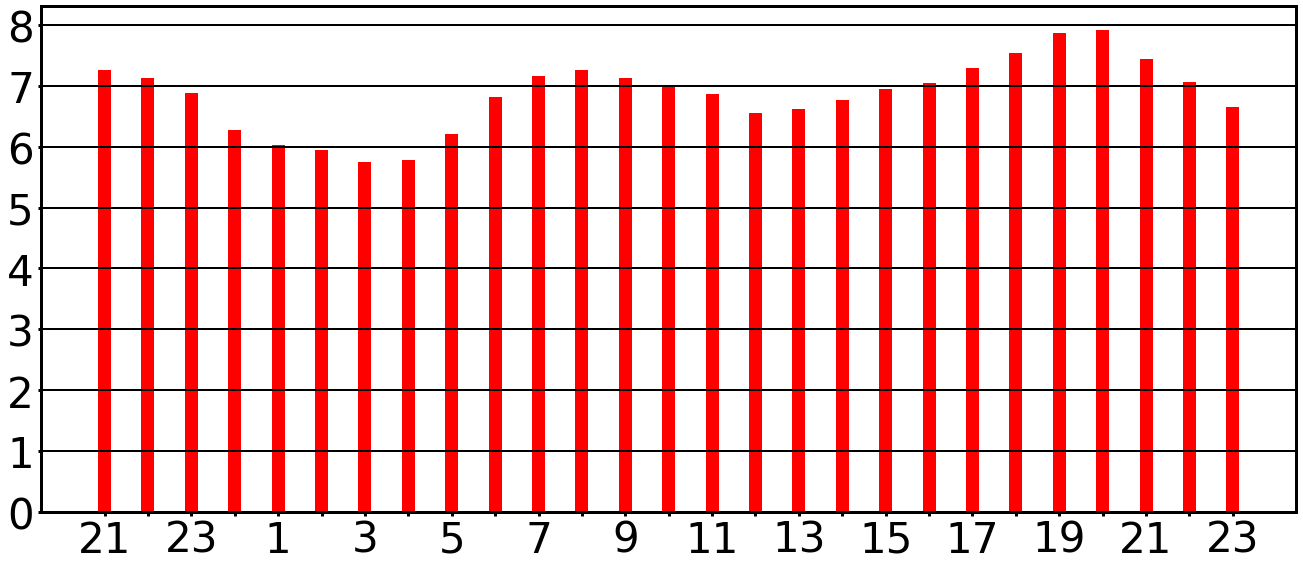

In [149]:
%matplotlib inline
import io
from PIL import Image
import utils
import configparser

CONFIG_FILENAME = 'config.ini'

with open(CONFIG_FILENAME) as f:
    config_parser = configparser.ConfigParser()
    config_parser.read_file(f)
    logger.info('Config: %s', config_parser.items('general'))
    config = config_parser['general']
    fonts = utils.get_fonts(config)

vsize = 448-200
hsize = 600
dpi = 80
factor=3

fig = plt.figure(figsize=((hsize/dpi*factor,vsize/dpi*factor)), frameon=False)
ax = plt.subplot()
vals = df_future.Price
hours = df_future.WeekHour
colors = ["green" if i < 3 else "red" for i in vals]
barplot = ax.bar(df_future.WeekHour, df_future.Price, 0.3, color=colors)
#ax.set_xlim([df_future.Hour[0], df_future.Hour[-1]])
ax.set_xticks(hours)
ax.set_xticklabels(df_future.Hour)
ax.grid(axis='y', linewidth=2, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3)

for i, tick in enumerate(ax.get_xticklabels()):
    tick.set_fontname('barlow-condensed')
    tick.set_fontsize(14*factor)
for tick in ax.get_xticklabels()[1::2]:
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname('barlow-condensed')
    tick.set_fontsize(14*factor)
plt.show()



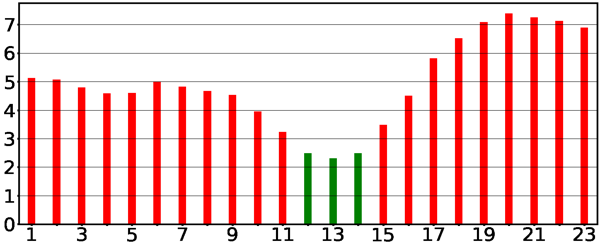

In [118]:
buf = io.BytesIO()

fig.savefig(buf, format="png", dpi=dpi,bbox_inches='tight')
fig.savefig('elpanel_plot.png', format="png", dpi=dpi)
buf.seek(0)
plot_image = Image.open(buf).convert("RGB")
newsize = (hsize, vsize)
im1 = plot_image.resize(newsize)
display(im1)
buf.close()

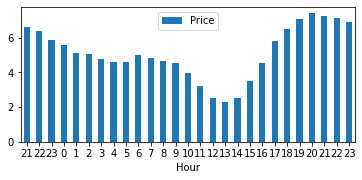

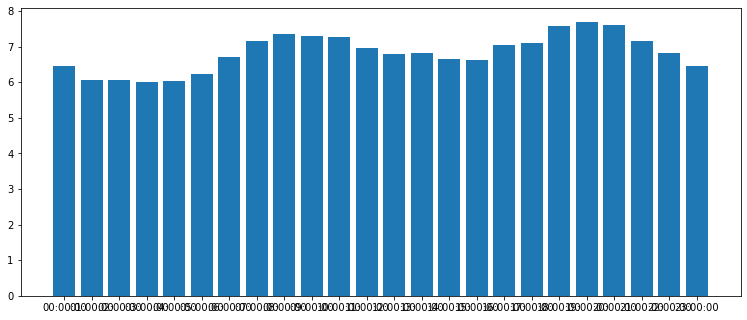

In [196]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0,0,1,1])
ax.bar(df_future.Time,df_future.Price)
plt.show()